In [1]:
%config Completer.use_jedi = False

#___________________________________________________________________________________________________________________
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

import matplotlib.pyplot as plt
import sys
import os
import time as time
import xarray as xr
from matplotlib.tri import Triangulation
import pandas as pa
import tripyview as tpv
import numpy as np

/tmp/ipykernel_1976820/2313588262.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('matplotlib notebook')
/tmp/ipykernel_1976820/2313588262.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
/tmp/ipykernel_1976820/2313588262.py:6: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftim

/albedo/home/pscholz/tripyview


## > <u>Load mesh:</u> 

In [2]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
meshpath='/albedo/work/user/pscholz/mesh_fesom2.0/core2_sorted/'
mesh=tpv.load_mesh_fesom2(meshpath, do_rot='None', focus=0, do_info=True, do_pickle=False, do_lsmask=False, do_augmpbnd=False)

 > load mesh from *.out files: /albedo/work/user/pscholz/mesh_fesom2.0/core2_sorted
/albedo/work/user/pscholz/mesh_fesom2.0/core2_sorted/nlvls.out
 > comp e_area
 > comp n_area
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_sorted
 > id              = core2_sorted
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = False
 > do cavity       = False
 > do lsmask       = False
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


## > <u>Load topo data + linear interpolation:</u>

In [34]:
#_________________________________________________________________________________________________
# do topography eiter on elements or vertices/nodes
do_on_elem       = False

#_________________________________________________________________________________________________
# should be a convolution smoothing be applied to the interpolated depth on nodes or elements
do_smoothconv    = True

# if do_smoothconv=True, Should particular narrow ocean straits be weaker smoothed
do_weaksmthStrt  = False

# apply interactive depth correction step
do_correctdepth  = True

#_________________________________________________________________________________________________
# which topographic data should be used for interpolation
# toponame, vname = 'ETOPO5'    , 'topo'
# toponame, vname = 'GEBCO1min' , 'topo'
# toponame, vname = 'GEBCO15sec', 'elevation'
toponame, vname = 'Rtopo2'    , 'topo'

#_________________________________________________________________________________________________
# save directory for depth and auxilary files
pathname = '/albedo/work/user/pscholz/mesh_fesom2.0/'
dname    = 'test_core2'
if do_on_elem      : dname = dname + '_dep@elem'
else               : dname = dname + '_dep@node'
if do_weaksmthStrt : dname = dname+'_nosmthStrt'
if do_correctdepth : dname = dname+'_correctdep'   
savedir = os.path.join(pathname,dname)
# savedir = None
print(savedir)

/albedo/work/user/pscholz/mesh_fesom2.0/test_core2_dep@node_correctdep


In [35]:
#_________________________________________________________________________________________________    
t1=time.time()
print(' --> load bathymetry: {}'.format(str(toponame)))
if toponame == 'GEBCO15sec':
    topofile = 'GEBCO_2021.nc'
    topodir  = '/albedo/work/projects/p_fesom/pscholz/work_ollie/bathmetry/topo_GEBCO15sec/'
    topopath = os.path.join(topodir,topofile)
    data     = xr.open_dataset(topopath, mask_and_scale=False, chunks={'lon':'auto', 'lat':'auto'})
    # data     = xr.open_dataset(topopath, mask_and_scale=False, chunks={'lon':8640, 'lat':4320})
    data     = data.rename({'lon':'dlon', 'lat':'dlat'}) # rename GEBCO dimensions

elif toponame == 'GEBCO1min':
    topofile = 'global_gebco_ibcao_1min_topo.nc'
    topodir  = '/albedo/work/projects/p_fesom/pscholz/work_ollie/bathmetry/topo_GEBCO1/'
    topopath = os.path.join(topodir,topofile)
    data     = xr.open_dataset(topopath, mask_and_scale=False, chunks={'lon':'auto', 'lat':'auto'})
    data     = data.rename({'DimLon':'dlon', 'DimLat':'dlat'}) # rename GEBCO dimensions
    data     = data.assign_coords(dlon=data.lon[:,0])
    data     = data.assign_coords(dlat=data.lat[:,1])

elif toponame == 'ETOPO5':
    topofile = 'etopo5_lonlat.nc'
    topodir  = '/albedo/work/projects/p_fesom/pscholz/work_ollie/bathmetry/topo_ETOPO5/'
    topopath = os.path.join(topodir,topofile)
    data     = xr.open_dataset(topopath, mask_and_scale=False)
    data     = data.rename({'lon':'dlon', 'lat':'dlat'}) # rename GEBCO dimensions

elif toponame == 'Rtopo2':    
    topofile = 'RTopo-2.0.1_30sec_global_topo_2016-12-13_bos_fix_lowres.nc'
    topodir  = '/albedo/work/projects/p_clidyn_work/nkolduno/OLDHOME/topo/'
    topopath = os.path.join(topodir,topofile)
    data     = xr.open_dataset(topopath, mask_and_scale=False, chunks={'lon':'auto', 'lat':'auto'})
    data     = data.rename({'DimLon':'dlon', 'DimLat':'dlat'}) # rename GEBCO dimensions
    data     = data.assign_coords(dlon=data.lon[:,0])
    data     = data.assign_coords(dlat=data.lat[:,1])
    
print(' -->', data.dims.mapping)

#_________________________________________________________________________________________________    
# kick out unnecessary variable from dataset
list_vname=list(data.keys())
if len(list_vname)>1:
    list_vname.remove(vname)
    data = data.drop(labels=list_vname) 
       
#_________________________________________________________________________________________________
# print info of regular grid boundaries 
print(' --> reg  [lon_s,lon_e, lat_s,lat_e]=[{},{},{},{}]'.format(str(data.dlon.data.min()), 
                                                                  str(data.dlon.data.max()),
                                                                  str(data.dlat.data.min()),
                                                                  str(data.dlat.data.max())))

print(' --> mesh [lon_s,lon_e, lat_s,lat_e]=[{},{},{},{}]'.format(str(mesh.n_x.min()), 
                                                                  str(mesh.n_x.max()),
                                                                  str(mesh.n_y.min()),
                                                                  str(mesh.n_y.max())))

#_________________________________________________________________________________________________
# see if longitude dimension needs to be periodically rolled so it agrees with 
# the fesom2 mesh focus 
# lon = data.coords[lon_name].values
lon = data.dlon.values
if any(lon>mesh.focus+180.0) or any(lon<mesh.focus-180.0):
    print(' --> change focus of regular grid ')
    # identify rolling index 
    if   any(lon>mesh.focus+180.0):
        idx = np.where(lon>mesh.focus+180.0)[0]
        idx_roll = idx[0]
        lon[idx] = lon[idx]-360.0
    elif any(lon<mesh.focus-180.0): 
        idx = np.where(lon<mesh.focus+180.0)[0]
        idx_roll = -idx[-1]
        lon[idx] = lon[idx]+360.0
        
    # shift longitude coordinates    
    data = data.assign_coords(dlon=lon)
        
    # periodically roll data together with longitude dimension
    data = data.roll(dict({'dlon':idx_roll}), roll_coords=True)    
    print(' --> reg  [lon_s,lon_e, lat_s,lat_e]=[{},{},{},{}]'.format(str(data.dlon.data.min()), str(data.dlon.data.max()),
                                                                      str(data.dlat.data.min()),str(data.dlat.data.max())))

#_________________________________________________________________________________________________ 
# eliminate land points --> set to 0.0
print(' --> eliminate land (set to 0.0)')
data[vname].data[data[vname].data>0] = 0

#_________________________________________________________________________________________________
# expand dimension periodically --> so that interpoaltion gives no nan at outer edges
if mesh.n_x.min()<data.dlon.data.min() or mesh.n_x.max()>data.dlon.data.max():
    print(' --> periodically augment boundaries (avoid nans at outer edges)')
    data = xr.concat([data.isel(dlon=-1), data , data.isel(dlon=0)], "dlon")
    data.dlon.values[ 0] = data.dlon.values[ 0]-360
    data.dlon.values[-1] = data.dlon.values[-1]+360
    print(' --> reg  [lon_s,lon_e, lat_s,lat_e]=[{},{},{},{}]'.format(str(data.dlon.data.min()), str(data.dlon.data.max()),
                                                                      str(data.dlat.data.min()),str(data.dlat.data.max())))

#_________________________________________________________________________________________________
# do linear interpolation, 1st define points for interpolation 
# add fesom2 mesh coordinatesro xarray dataset
if do_on_elem: 
    print(' --> interpolate bathymetry on elements')
    e_x  = xr.DataArray(mesh.n_x[mesh.e_i].sum(axis=1)/3.0, dims="e2dn")
    e_y  = xr.DataArray(mesh.n_y[mesh.e_i].sum(axis=1)/3.0, dims="e2dn")
    data = data.interp(dlon=e_x, dlat=e_y, method='linear')
else: 
    print(' --> interpolate bathymetry on vertices')
    n_x  = xr.DataArray(mesh.n_x, dims="n2dn")
    n_y  = xr.DataArray(mesh.n_y, dims="n2dn")
    data = data.interp(dlon=n_x, dlat=n_y, method='linear')

#_________________________________________________________________________________________________
# do final dask computation (takes some time)...
print(' --> finalize in case of chunking (for GEBCO15sec takes a bit)')
data = data[vname].compute()

#_________________________________________________________________________________________________
# from here on it an np.array
print(' --> convert topography to np.array')
data = -np.abs(data.values)

#_________________________________________________________________________________________________
print(' --> finished')
print(' --> elapsed time: {}'.format(str(time.time()-t1)))

 --> load bathymetry: Rtopo2
 --> {'dlat': 21601, 'nax': 2, 'dlon': 43201}
 --> reg  [lon_s,lon_e, lat_s,lat_e]=[-180.0,180.0,-90.0,90.0]
 --> mesh [lon_s,lon_e, lat_s,lat_e]=[-179.9997,179.9997,-78.517,89.958]
 --> eliminate land (set to 0.0)
 --> interpolate bathymetry on vertices
 --> finalize in case of chunking (for GEBCO15sec takes a bit)
 --> convert topography to np.array
 --> finished
 --> elapsed time: 4.832503080368042


## > <u> Set postprocessing of topo:</u>

In [36]:
#_____________________________________________________________________________________________    
rel_cent_weight = 2.0 # >=1
num_iter        = 2
set_min_dep     = [True, -10.0]
set_max_dep     = [True, -6000.0]

#_________________________________________________________________________________________
# set area with weaker smoothing parameter
#special_smth_boxlist.append([lon_s, lon_e,  lat_s,  lat_e,  enhance_coeff]) # Qiang Box 
weaksmth_coeff = 3.0 
weaksmth_boxlist = list()
weaksmth_boxlist.append([-180.00, -158.00,  63.00,  80.00, weaksmth_coeff   ]) # Qiang Box 
weaksmth_boxlist.append([ 178.00,  180.00,  63.00,  80.00, weaksmth_coeff   ]) # Qiang Box

#_____________________________________________________________________________________________
# only do smoothing when do_smoothconv=True, standard center smoothing weight is 1 for
# weak smoothing increase center weight to 3.0 or 3.0^2 for do_nosmthStrt=True
if do_weaksmthStrt:
    # much weaker smoothing in straits
    weaksmth_boxlist.append([  -6.00,   -2.50,  35.00,  37.00, weaksmth_coeff**3]) # Strait of Gibraltar
    weaksmth_boxlist.append([ -67.00,  -64.25, -64.00, -55.50, weaksmth_coeff**3]) # Drake Passage
    weaksmth_boxlist.append([ -28.00,  -25.50,  65.50,  67.00, weaksmth_coeff**3]) # Denmark Strait
    weaksmth_boxlist.append([ -13.50,   -1.00,  59.00,  65.00, weaksmth_coeff**3]) # Iceland Scotland Ridge
    weaksmth_boxlist.append([ -10.00,    4.00,  80.00,  82.00, weaksmth_coeff**3]) # Fram Strait 

#### > <u> Set min, max of topo:</u>

In [37]:
#_____________________________________________________________________________________________
# set min/max water depth
if set_min_dep[0]: data[data>-np.abs(set_min_dep[1])] = -np.abs(set_min_dep[1]) 
if set_max_dep[0]: data[data<-np.abs(set_max_dep[1])] = -np.abs(set_max_dep[1])
zmin, zmax = data.min(), data.max()
if set_max_dep[0] or set_min_dep[0]: print(' --> after applying min/max depth limitation')
print(' --> min, max depth: {}, {}'.format(str(zmin), str(zmax)))    


 --> after applying min/max depth limitation
 --> min, max depth: -6000.0, -10.0


#### ><u> Compute smoothing of topo:</u>

In [38]:
#_____________________________________________________________________________________________
# apply convolution smoothing, standard center weight is 1 in case of weaker smoothing center 
# becomes 3 or 3^2 in case of weak strait smoothing
data_smth = data.copy()
if do_smoothconv:
    #_____________________________________________________________________________________________
    # save orig depth (without smoothing, but with min/max depth adaption)
    if savedir is not None:
        if do_on_elem : savefile = 'depth@elem_{}_orig.out'.format(str(toponame))
        else:           savefile = 'depth@node_{}_orig.out'.format(str(toponame))
        print(' --> save original topo @:{}'.format(str(os.path.join(savedir,savefile))))
        if not os.path.isdir(savedir): os.makedirs(savedir)
        fid = pa.DataFrame(data)
        fid.to_csv(os.path.join(savedir,savefile), index=False, header=False, float_format='%.2f')

    #_____________________________________________________________________________________________
    # compute smoothing either on nodes or element
    if not do_on_elem:
        # compute node neighbourhood
        n_nghbr_n   = tpv.do_node_neighbour(mesh)

        # compute smoothing
        data_smth   = tpv.do_node_smoothing(mesh, data_smth, n_nghbr_n, 
                                            weaksmth_boxlist, rel_cent_weight, num_iter)

    else: 
        # compute elem neighbourhood
        e_nghbr_e   = tpv.do_elem_neighbour(mesh)

        # compute smoothing
        data_smth   = tpv.do_elem_smoothing(mesh, data_smth, e_nghbr_e, 
                                            weaksmth_boxlist, rel_cent_weight, num_iter)

    #_____________________________________________________________________________________________
    # save smoothed depth
    if savedir is not None:
        if do_on_elem : savefile = 'depth@elem_{}_smth.out'.format(str(toponame))
        else:           savefile = 'depth@node_{}_smth.out'.format(str(toponame))    
        print(' --> save smoothed topo @:{}'.format(str(os.path.join(savedir,savefile))))
        if not os.path.isdir(savedir): os.makedirs(savedir)
        fid = pa.DataFrame(data_smth)
        fid.to_csv(os.path.join(savedir,savefile), index=False, header=False, float_format='%.2f')
    print(' --> finished')    

 --> save original topo @:/albedo/work/user/pscholz/mesh_fesom2.0/test_core2_dep@node_correctdep/depth@node_Rtopo2_orig.out
 --> compute node neighbourhood
 --> compute node smoothing
     iter: 0
     iter: 1
 --> save smoothed topo @:/albedo/work/user/pscholz/mesh_fesom2.0/test_core2_dep@node_correctdep/depth@node_Rtopo2_smth.out
 --> finished


#### ><u> Compute correction of topo:</u>
<u>Mouse Input:</u> <br>

    [left  ] ... select certain scatter point (green ring)
    [right ] ... zoom out to original xlim, ylim

<u>Keyboard Input:</u> <br>

    [  c   ]   ... choose depth value for certain scatter points (value is selected by slider)
    [  e   ]   ... finish choosing exit interactive mode
    [  +   ]   ... zoom in 
    [  -   ]   ... zoom in  
    [  up  ]   ... move up  
    [ down ]   ... move down  
    [ left ]   ... move left  
    [ right]   ... move right  
    
    [   n  ]   ... go to next correction box entry --> crctdep_boxlist[i+1]
    [   p  ]   ... go to previous correction box entry --> crctdep_boxlist[i-1]
    
    [   1  ]   ... single point selection
    [   2  ]   ... rectangular box point selection (with mouse drag)
    [   3  ]   ... polygon box point selection (select polygon points with mouse klick, close polygon)

<IPython.core.display.Javascript object>


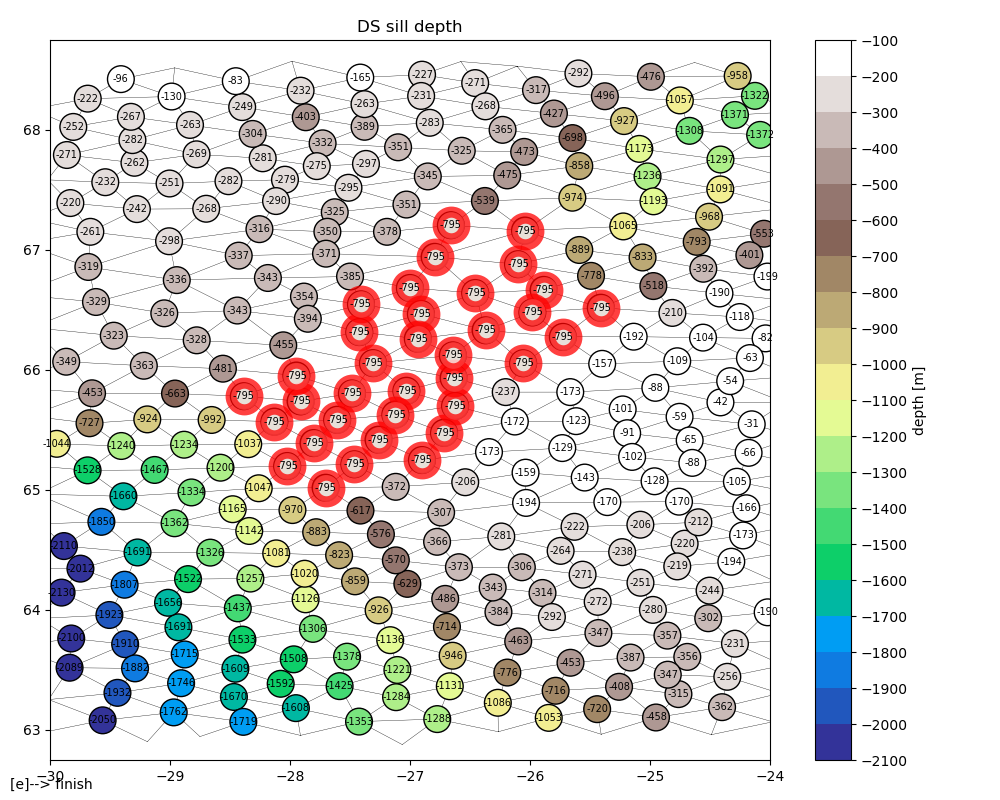

interactive(children=(IntSlider(value=100, continuous_update=False, description='$\\bf\\color{red}{\\textrm{sc…

interactive(children=(IntRangeSlider(value=(-2100, -31), continuous_update=False, description='$\\bf\\color{re…

interactive(children=(Checkbox(value=False, description='show txt orig:', indent=False), Output()), _dom_class…

interactive(children=(Checkbox(value=False, description='show txt corrected:', indent=False), Output()), _dom_…

interactive(children=(Checkbox(value=True, description='center selction:', indent=False), Output()), _dom_clas…

In [39]:
# the interactive correction routine works in moment best with the packages jupyter_server==1.23.6,
# jupyter_client==7.3.2, tornado=6.1 --> especially tornado>=6.2 causes trouble in moment 

### dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem_correctdep/depth@elem_GEBCO15sec_smth+crct_FBC-977.out'
# with open(dname) as f: data_load = np.array([next(f).rstrip() for x in range(data.size)]).astype(float)
       
if do_correctdepth:
    #_________________________________________________________________________________________________
    crctdep_boxlist = list()
    crctdep_boxlist.append([ [ -30.00,  -24.00,  63.00,  68.50],'DS'])  # Denmark Strait    
#     crctdep_boxlist.append([ [ -13.00,   -7.50,  62.25,  64.75],'ISR']) # Iceland-Scotland-Ridge  
#     crctdep_boxlist.append([ [ -15.00,   -8,  62.00,  65],'ISR']) # Iceland-Scotland-Ridge  
#     crctdep_boxlist.append([ [  -9.50,   -3.00,  59.50,  62.00],'FBC']) # Faroe-Bank-Channel
#     crctdep_boxlist.append([ [-20, -5, 52, 59.5],'RT']) # Rockall Troughe
    crctdep_boxlist.append([ [-9, -2, 33.0, 39.0],'GS']) # Gibraltar strait
#     crctdep_boxlist.append([ [-5, 20, 75.0, 85.0],'YP']) # Yamak Plateau
#     crctdep_boxlist.append([ [-5, 7, 76.0, 83.0],'FS']) # Fram Strait
#     crctdep_boxlist.append([ [-15.5, -1.0, 59.5, 65.0],'ISR+FBC']) # Iceland-Scotland-Ridge + Faroe-Bank-Channel
    #_____________________________________________ee____________________________________________________
    select = tpv.select_scatterpts_depth(mesh, data_smth, crctdep_boxlist, cname='terrain', do_elem=do_on_elem, 
                                         do_tri=True, do_grid=False, do_axeq=True, seldeprange=[-3000, -100])
#     select = tpv.select_scatterpts_depth(mesh, data_load, crctdep_boxlist, cname='terrain', do_tri=True)

#### ><u> Save correction of topo:</u>

In [40]:
if do_correctdepth:
    data_crct=select.data.copy()
    str_crct ='+crct'
    
    #_____________________________________________________________________________________________
    for box in crctdep_boxlist:
        if do_on_elem: idx = tpv.do_boxmask(mesh, box[0], do_elem=True)
        else         : idx = tpv.do_boxmask(mesh, box[0], do_elem=False)
        if any(np.abs(data_crct[idx]-data_smth[idx]) >= 1.0):
            if select.do_reldep:
                str_crct = str_crct + "_{:s}{:.0f}%".format(box[1],select.seldep)
            else:    
                aux = data_crct[idx]
                aux = aux[np.abs(data_crct[idx]-data_smth[idx])>= 1.0].mean()
                str_crct = str_crct + "_{:s}{:.0f}".format(box[1],aux)
       
    #_____________________________________________________________________________________________
    # save smoothed depth
    if savedir is not None:
        if do_on_elem : savefile = 'depth@elem_{:s}_smth{:s}.out'.format(str(toponame),str(str_crct))
        else:           savefile = 'depth@node_{:s}_smth{:s}.out'.format(str(toponame),str(str_crct)) 
        print(' --> save smoothed topo @:{}'.format(str(os.path.join(savedir,savefile))))
        if not os.path.isdir(savedir): os.makedirs(savedir)
        fid = pa.DataFrame(data_crct)
        fid.to_csv(os.path.join(savedir,savefile), index=False, header=False, float_format='%.2f')

 --> save smoothed topo @:/albedo/work/user/pscholz/mesh_fesom2.0/test_core2_dep@node_correctdep/depth@node_Rtopo2_smth+crct_DS-795.out


#### ><u> Plot correction of topo:</u>

<IPython.core.display.Javascript object>


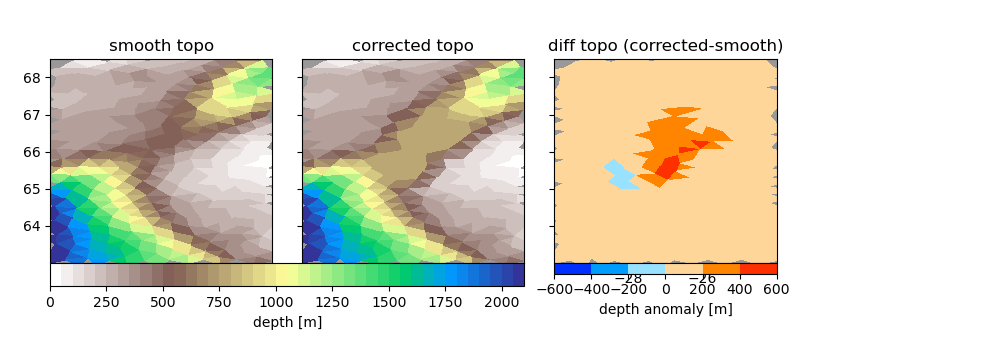

In [41]:
if do_correctdepth:
    
    #_____________________________________________________________________________________________
    for box in crctdep_boxlist:
        idxe = tpv.do_boxmask(mesh, box[0], do_elem=True)
        idx  = idxe
        if not do_on_elem: 
            idxn = tpv.do_boxmask(mesh, box[0], do_elem=False)
            idx  = idxn
        
        if any((data_crct[idx]-data_smth[idx]) != 0)==False: continue
        trisel = Triangulation(mesh.n_x, mesh.n_y, mesh.e_i[idxe,:])
        e_x = mesh.n_x[mesh.e_i[idxe,:]].sum(axis=1)/3.0
        e_y = mesh.n_y[mesh.e_i[idxe,:]].sum(axis=1)/3.0
        
        #_____________________________________________________________________________________________
        fig, ax = plt.subplots(1, 3, figsize=[10,3.5], sharex=True, sharey=True)
        fig.tight_layout()

        #_____________________________________________________________________________________________
        cmin1, cmax1  = 0, 6000
        cmax1   = np.abs(data_crct[idx]).max()
        clevel1 = np.arange(cmin1, cmax1+1, 50)

        #_____________________________________________________________________________________________
        if do_on_elem: data_plot = np.abs(data_smth[idxe])
        else         : data_plot = np.abs(data_smth)
        hp1=ax[0].tripcolor(trisel,data_plot, vmin=clevel1[0], vmax=clevel1[-1], cmap=plt.get_cmap('terrain_r',clevel1.size-1))
        ax[0].set_title('smooth topo')
        #_____________________________________________________________________________________________
        if do_on_elem: data_plot = np.abs(data_crct[idxe])
        else         : data_plot = np.abs(data_crct)
        hp1=ax[1].tripcolor(trisel,data_plot, vmin=clevel1[0], vmax=clevel1[-1], cmap=plt.get_cmap('terrain_r',clevel1.size-1))
        ax[1].set_title('corrected topo')
        #_____________________________________________________________________________________________
        if do_on_elem: data_plot = np.abs(data_crct[idxe])-np.abs(data_smth[idxe])
        else         : data_plot = np.abs(data_crct)-np.abs(data_smth)
        cmax2  = np.maximum(np.abs(data_plot.min()), data_plot.max())
        cmin2  = -cmax2
        cmap, clevel2, cref = tpv.colormap_c2c(cmin2, cmax2, 0, 5, 'blue2red')
        
        hp2=ax[2].tripcolor(trisel, data_plot, vmin=clevel2[0], vmax=clevel2[-1], cmap=cmap) #lt.get_cmap('RdBu_r',clevel2.size-1))
        ax[2].set_title('diff topo (corrected-smooth)')
        
        #_____________________________________________________________________________________________
        for axi in ax:
            axi.set_facecolor([0.6 ,0.6,0.6])
            axi.set_xlim( e_x.min(), e_x.max() )
            axi.set_ylim( e_y.min(), e_y.max() )
            axi.set_aspect('equal')
        #_____________________________________________________________________________________________
        cbar1 = plt.colorbar(hp1, ax=ax[:2], label='depth [m]', orientation='horizontal')
        cbar2 = plt.colorbar(hp2, ax=ax[2] , ticks=clevel2, label='depth anomaly [m]', orientation='horizontal')
        #_____________________________________________________________________________________________
        nax = len(ax)
        ax_pos = np.zeros((nax,4))
        for jj in range(0,nax):
            aux = ax[jj].get_position()
            ax_pos[jj,:] = np.array([aux.x0, aux.y0, aux.width, aux.height])

        x0, y0, x1, y1 = 0.05, 0.25, 0.9, 0.9
        w,  h  = ax_pos[:,2].min(), ax_pos[:,3].min()
        wg, hg = 0.03, 0.05
        ax[0].set_position( [x0+(w+wg)*0, y0+(h+hg)*0, w, h] )
        ax[1].set_position( [x0+(w+wg)*1, y0+(h+hg)*0, w, h] )
        ax[2].set_position( [x0+(w+wg)*2, y0+(h+hg)*0, w, h] )
        cbar1_pos = cbar1.ax.get_position()
        cbar2_pos = cbar2.ax.get_position()
        cbar1.ax.set_position([x0, y0-0.125, w*2+wg, cbar2_pos.height*1.0])
        cbar1.ax.set_aspect('auto')
        cbar2.ax.set_position([x0+(w+wg)*2, y0-0.125, w, cbar2_pos.height*1.0])
        cbar2.ax.set_aspect('auto')
        plt.show(block=False)        
    

##  > <u>Plot original, smoothed, corrected topos:</u>

<IPython.core.display.Javascript object>


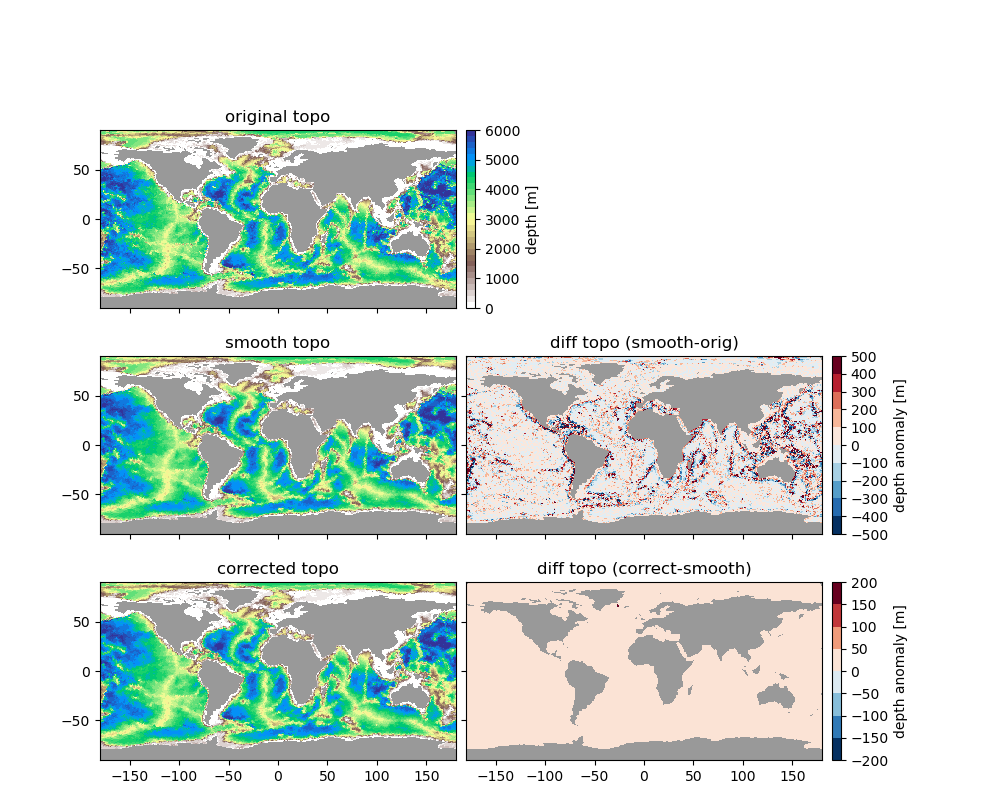

In [42]:
tri = Triangulation(mesh.n_x, mesh.n_y, mesh.e_i[mesh.e_pbnd_0,:])
fig, ax = plt.subplots(3, 2, figsize=[10,8], sharex=True, sharey=True)
fig.tight_layout()

#_____________________________________________________________________________________________
cmin1, cmax1  = 0, 6000
clevel1 = np.arange(cmin1, cmax1+1, 200)

#_____________________________________________________________________________________________
if do_on_elem: data_plot = np.abs(data[mesh.e_pbnd_0])
else:          data_plot = np.abs(data)
hp1=ax[0,0].tripcolor(tri,data_plot, vmin=clevel1[0], vmax=clevel1[-1], cmap=plt.get_cmap('terrain_r',clevel1.size-1))
ax[0,0].set_title('original topo')

#_____________________________________________________________________________________________
if do_smoothconv:
    if do_on_elem: data_plot = np.abs(data_smth[mesh.e_pbnd_0])
    else:          data_plot = np.abs(data_smth)
    hp1=ax[1,0].tripcolor(tri,data_plot, vmin=clevel1[0], vmax=clevel1[-1], cmap=plt.get_cmap('terrain_r',clevel1.size-1))
    ax[1,0].set_title('smooth topo')
    #_____________________________________________________________________________________________
    if do_on_elem: data_plot = np.abs(data_smth[mesh.e_pbnd_0])-np.abs(data[mesh.e_pbnd_0])
    else:          data_plot = np.abs(data_smth)-np.abs(data)
    cmin2, cmax2  = [-500, 500]
    clevel2 = np.arange(cmin2, cmax2+1, 100)
    hp2=ax[1,1].tripcolor(tri, data_plot, vmin=clevel2[0], vmax=clevel2[-1], cmap=plt.get_cmap('RdBu_r',clevel2.size-1))
    ax[1,1].set_title('diff topo (smooth-orig)')

#_____________________________________________________________________________________________
if do_correctdepth:
    if do_on_elem: data_plot = np.abs(data_crct[mesh.e_pbnd_0])
    else:          data_plot = np.abs(data_crct)
    hp1=ax[2,0].tripcolor(tri,data_plot, vmin=clevel1[0], vmax=clevel1[-1], cmap=plt.get_cmap('terrain_r',clevel1.size-1))
    ax[2,0].set_title('corrected topo')
    #_____________________________________________________________________________________________
    if do_on_elem: data_plot = np.abs(data_crct[mesh.e_pbnd_0])-np.abs(data_smth[mesh.e_pbnd_0])
    else:          data_plot = np.abs(data_crct)-np.abs(data_smth)
    cmin3, cmax3  = [-200, 200]
    clevel3 = np.arange(cmin3, cmax3+1, 50)
    hp3=ax[2,1].tripcolor(tri, data_plot, vmin=clevel3[0], vmax=clevel3[-1], cmap=plt.get_cmap('RdBu_r',clevel3.size-1))
    ax[2,1].set_title('diff topo (correct-smooth)')
    
#_____________________________________________________________________________________________
for axi in ax.flatten():
    axi.set_facecolor([0.6 ,0.6,0.6])
    axi.set_xlim(-180,180)
    axi.set_ylim(-90,90)
    axi.set_aspect('equal')

#_____________________________________________________________________________________________
cbar1 = plt.colorbar(hp1, ax=ax[0,0], label='depth [m]')
cbar2 = plt.colorbar(hp2, ax=ax[1,1], ticks=clevel2, label='depth anomaly [m]')
cbar3 = plt.colorbar(hp3, ax=ax[2,1], ticks=clevel3, label='depth anomaly [m]')

#_____________________________________________________________________________________________
ax  = ax.flatten()
nax = len(ax)
ax_pos = np.zeros((nax,4))
for jj in range(0,nax):
    aux = ax[jj].get_position()
    ax_pos[jj,:] = np.array([aux.x0, aux.y0, aux.width, aux.height])

x0, y0, x1, y1 = 0.1, 0.05, 0.9, 0.9
w,  h  = ax_pos[:,2].min(), ax_pos[:,3].min()
wg, hg = 0.01, 0.06

ax[0].set_position( [x0+(w+wg)*0, y0+(h+hg)*2, w, h] )
ax[1].set_position( [x0+(w+wg)*1, y0+(h+hg)*2, w, h] )
ax[2].set_position( [x0+(w+wg)*0, y0+(h+hg)*1, w, h] )
ax[3].set_position( [x0+(w+wg)*1, y0+(h+hg)*1, w, h] )
ax[4].set_position( [x0+(w+wg)*0, y0+(h+hg)*0, w, h] )
ax[5].set_position( [x0+(w+wg)*1, y0+(h+hg)*0, w, h] )

cbar1_pos = cbar1.ax.get_position()
cbar2_pos = cbar2.ax.get_position()
cbar3_pos = cbar3.ax.get_position()
cbar1.ax.set_position([x0+(w+wg)*1, y0+(h+hg)*2, cbar1_pos.width*1.0, h])
cbar2.ax.set_position([x0+(w+wg)*2, y0+(h+hg)*1, cbar1_pos.width*1.0, h])
cbar3.ax.set_position([x0+(w+wg)*2, y0+(h+hg)*0, cbar1_pos.width*1.0, h])
cbar1.ax.set_aspect('auto')
cbar2.ax.set_aspect('auto')
cbar3.ax.set_aspect('auto')

ax[1].remove()

plt.show(block=False)

##  > <u>Combine different correct bathymetries from singular files into final topography:</u> 

In [12]:
if do_on_elem: 
    ndi = mesh.n2de
    dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem_correctdep/depth@elem_GEBCO15sec_smth.out'
else         : 
    ndi = mesh.n2dn
    dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@node_correctdep/depth@node_GEBCO15sec_smth.out'
with open(dname) as f: data_base = np.array([next(f).rstrip() for x in range(ndi)]).astype(float)
       

#_________________________________________________________________________________________________
str_crct ='+crct'
crctdep_boxlist = list()
if do_on_elem: 
    dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem_correctdep/depth@elem_GEBCO15sec_smth+crct_DS-610.out'
    crctdep_boxlist.append([ [ -29.00,  -25.00,  65.00,  67.50],'DS', dname])  # Denmark Strait    
    dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem_correctdep/depth@elem_GEBCO15sec_smth+crct_ISR-356.out'
    crctdep_boxlist.append([ [ -13.00,   -7.50,  62.25,  64.75],'ISR', dname]) # Iceland-Scotland-Ridge  
    dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem_correctdep/depth@elem_GEBCO15sec_smth+crct_FBC-990.out'
    crctdep_boxlist.append([ [  -9.50,   -3.00,  59.50,  62.00],'FBC', dname]) # Faroe-Bank-Channel
    dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem_correctdep/depth@elem_GEBCO15sec_smth+crct_RT-738.out'
    crctdep_boxlist.append([ [-20, -5, 52, 59.5],'RT', dname]) # Rockall Trough
    dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem_correctdep/depth@elem_GEBCO15sec_smth+crct_GS-190.out'
    crctdep_boxlist.append([  [-9, -2, 35.0, 37.0],'GS', dname]) # Gibraltar Strait 
    # dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem_correctdep/depth@elem_GEBCO15sec_smth+crct_YP-555.out'
    # crctdep_boxlist.append([ [-5, 20, 75.0, 85.0],'YP', dname]) # Yamak Plateau
    # dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem_correctdep/depth@elem_GEBCO15sec_smth+crct_FS-1752.out'
    # crctdep_boxlist.append([ [-5, 7, 76.0, 83.0] ,'FS', dname]) # Fram Strait
else:
    dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@node_correctdep/depth@node_GEBCO15sec_smth+crct_DS-610.out'
    crctdep_boxlist.append([ [ -29.00,  -25.00,  65.00,  67.50],'DS', dname])  # Denmark Strait    
    dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@node_correctdep/depth@node_GEBCO15sec_smth+crct_ISR-358.out'
    crctdep_boxlist.append([ [ -13.00,   -7.50,  62.25,  64.75],'ISR', dname]) # Iceland-Scotland-Ridge  
    dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@node_correctdep/depth@node_GEBCO15sec_smth+crct_FBC-990.out'
    crctdep_boxlist.append([ [  -9.50,   -3.00,  59.50,  62.00],'FBC', dname]) # Faroe-Bank-Channel
    dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@node_correctdep/depth@node_GEBCO15sec_smth+crct_RT-722.out'
    crctdep_boxlist.append([ [-20, -5, 52, 59.5],'RT', dname]) # Rockall Trough
    dname = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@node_correctdep/depth@node_GEBCO15sec_smth+crct_GS-190.out'
    crctdep_boxlist.append([  [-9, -2, 35.0, 37.0],'GS', dname]) # Gibraltar Strait 


#_________________________________________________________________________________________________
for box in crctdep_boxlist:
    
    #_________________________________________________________________________________________________
    with open(box[2]) as f: data_crct = np.array([next(f).rstrip() for x in range(ndi)]).astype(float)
    
    #_________________________________________________________________________________________________
    if do_on_elem: idx = do_boxmask(mesh, box[0], do_elem=True)
    else         : idx = do_boxmask(mesh, box[0], do_elem=False)
    if any(np.abs(data_crct[idx]-data_base[idx]) >= 1.0):
        
        #_____________________________________________________________________________________________
        tri = Triangulation(mesh.n_x, mesh.n_y, mesh.e_i[mesh.e_pbnd_0,:])
        fig, ax = plt.subplots(1, 1, figsize=[10,5], sharex=True, sharey=True)
        cmin1, cmax1  = -50, 50
        clevel1 = np.arange(cmin1, cmax1+1, 1)
        if do_on_elem: data_plot = np.abs(data_base[mesh.e_pbnd_0])-np.abs(data_crct[mesh.e_pbnd_0])
        else:          data_plot = np.abs(data_base) - np.abs(data_crct)
        hp1=ax.tripcolor(tri,data_plot, vmin=clevel1[0], vmax=clevel1[-1], cmap=plt.get_cmap('RdBu_r',clevel1.size-1))
        cbar1 = plt.colorbar(hp1, ax=ax, label='depth anomaly [m]')
        ax.set_title('depth anomaly')
        ax.set_facecolor([0.6 ,0.6,0.6])
        ax.set_xlim(-180,180)
        ax.set_ylim(-90,90)
        ax.set_aspect('equal')
        
        
        #_____________________________________________________________________________________________
        aux = data_crct[idx]
        aux = aux[np.abs(data_crct[idx]-data_base[idx])>= 1.0]
        aux = aux.mean()
        str_crct = str_crct + "_{:s}{:.0f}".format(box[1],aux)
#         print(str_crct)        
        
        idx_box  = np.where(idx==True)[0]
        idx_chng = np.where(np.abs(data_crct[idx]-data_base[idx])>= 1.0)[0]
        print(data_base[idx_box[idx_chng]])
        print(data_crct[idx_box[idx_chng]])
        print(data_crct[idx_box[idx_chng]]-data_base[idx_box[idx_chng]])
        data_base[idx_box[idx_chng]] = data_crct[idx_box[idx_chng]] 

#_____________________________________________________________________________________________
# save smoothed depth
if savedir is not None:
    if do_on_elem : savefile = 'depth@elem_{:s}_smth{:s}.out'.format(str(toponame),str(str_crct))
    else:           savefile = 'depth@node_{:s}_smth{:s}.out'.format(str(toponame),str(str_crct)) 
    print(' --> save smoothed topo @:{}'.format(str(os.path.join(savedir,savefile))))
    if not os.path.isdir(savedir): os.makedirs(savedir)
    fid = pa.DataFrame(data_base)
    fid.to_csv(os.path.join(savedir,savefile), index=False, header=False, float_format='%.2f')

FileNotFoundError: [Errno 2] No such file or directory: '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@node_correctdep/depth@node_GEBCO15sec_smth.out'